#### 06 Evaluation & Comparison

**Goal:**  
Load all saved models (classic ML + transfer learning), evaluate on test set, and compare their metrics using tables and plots.

- Input: Test data, saved models
- Output: Model metrics, comparison tables, and visualizations


In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve
import joblib
import tensorflow as tf


In [6]:
base_dir = '../chest_xray'
test_dir = os.path.join(base_dir, 'test')
IMG_SIZE = (224, 224)
BATCH_SIZE = 32
CLASSES = ['NORMAL', 'PNEUMONIA']

model_dir = 'models/saved/Classic_ML_Models'


In [7]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

test_gen = ImageDataGenerator(rescale=1./255).flow_from_directory(
    test_dir,
    target_size=IMG_SIZE,
    color_mode='grayscale',  # Use 'rgb' for TL models, 'grayscale' for custom CNN/classic ML
    batch_size=BATCH_SIZE,
    class_mode='binary',
    shuffle=False
)


Found 624 images belonging to 2 classes.


In [8]:
# Rebuild test feature set as in 03_classic_ml_models.ipynb
from PIL import Image
import cv2

def extract_features(img_path):
    img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
    img = cv2.resize(img, (128, 128))
    img = img.astype('float32') / 255.0
    pixels = img.flatten()
    hist = cv2.calcHist([img], [0], None, [16], [0,1]).flatten()
    mean = np.mean(img)
    std = np.std(img)
    features = np.concatenate([pixels, hist, [mean, std]])
    return features

def build_feature_dataset(data_dir, classes):
    X, y = [], []
    for label_idx, label in enumerate(classes):
        label_dir = os.path.join(data_dir, label)
        files = os.listdir(label_dir)
        for fname in files:
            fpath = os.path.join(label_dir, fname)
            try:
                features = extract_features(fpath)
                if features is None or np.any(pd.isnull(features)):
                    continue
                X.append(features)
                y.append(label_idx)
            except:
                continue
    return np.array(X), np.array(y)

X_test_ml, y_test_ml = build_feature_dataset(test_dir, CLASSES)
from sklearn.preprocessing import StandardScaler
scaler = joblib.load(os.path.join(model_dir, 'scaler.pkl')) if os.path.exists(os.path.join(model_dir, 'scaler.pkl')) else StandardScaler()
X_test_ml_scaled = scaler.fit_transform(X_test_ml)


In [10]:
# List of saved classical ML models
ml_model_files = [
    'logistic_regression.pkl',
    'svm.pkl',
    'random_forest.pkl',
    'naive_bayes.pkl',
    'decision_tree.pkl',
    'adaboost.pkl',
    'gradient_boosting.pkl'
]

ml_results = []

for model_file in ml_model_files:
    model_path = os.path.join(model_dir, model_file)
    if not os.path.exists(model_path):
        print(f"Model not found: {model_path}")
        continue
    model = joblib.load(model_path)
    y_pred = model.predict(X_test_ml_scaled)
    acc = np.mean(y_pred == y_test_ml)
    report = classification_report(y_test_ml, y_pred, target_names=CLASSES, output_dict=True)
    cm = confusion_matrix(y_test_ml, y_pred)
    print(f"Model: {model_file.split('.')[0]}\n", classification_report(y_test_ml, y_pred, target_names=CLASSES))
    ml_results.append({
        'Model': model_file.split('.')[0],
        'Accuracy': acc,
        'Precision': report['weighted avg']['precision'],
        'Recall': report['weighted avg']['recall'],
        'F1-score': report['weighted avg']['f1-score'],
        'Confusion Matrix': cm
    })


Model: logistic_regression
               precision    recall  f1-score   support

      NORMAL       0.95      0.45      0.61       234
   PNEUMONIA       0.75      0.98      0.85       390

    accuracy                           0.79       624
   macro avg       0.85      0.72      0.73       624
weighted avg       0.82      0.79      0.76       624

Model: svm
               precision    recall  f1-score   support

      NORMAL       0.94      0.51      0.66       234
   PNEUMONIA       0.77      0.98      0.86       390

    accuracy                           0.80       624
   macro avg       0.86      0.75      0.76       624
weighted avg       0.83      0.80      0.79       624

Model: random_forest
               precision    recall  f1-score   support

      NORMAL       0.93      0.37      0.53       234
   PNEUMONIA       0.72      0.98      0.83       390

    accuracy                           0.75       624
   macro avg       0.82      0.68      0.68       624
weighted avg

In [11]:
# Helper: get correct color mode and preprocessing for each model
model_dir1= 'models/saved'

tl_model_files = [
    ('resnet50_best.h5', 'ResNet50', tf.keras.applications.resnet.preprocess_input, 'rgb'),
    ('densenet121_best.h5', 'DenseNet121', tf.keras.applications.densenet.preprocess_input, 'rgb'),
    ('efficientnetb0_best.h5', 'EfficientNetB0', tf.keras.applications.efficientnet.preprocess_input, 'rgb'),
    ('vgg16_best.h5', 'VGG16', tf.keras.applications.vgg16.preprocess_input, 'rgb'),
    ('custom_cnn_pneumonia.h5', 'CustomCNN', None, 'grayscale')
]

tl_results = []

for model_file, model_name, preprocess_func, color_mode in tl_model_files:
    model_path = os.path.join(model_dir1, model_file)
    if not os.path.exists(model_path):
        print(f"Model not found: {model_path}")
        continue

    # Set up generator for this model
    gen = ImageDataGenerator(preprocessing_function=preprocess_func if preprocess_func else None).flow_from_directory(
        test_dir,
        target_size=IMG_SIZE,
        color_mode=color_mode,
        batch_size=BATCH_SIZE,
        class_mode='binary',
        shuffle=False
    )

    # Load model and predict
    model = tf.keras.models.load_model(model_path)
    y_probs = model.predict(gen, verbose=1)
    y_pred = (y_probs > 0.5).astype(int).flatten()
    y_true = gen.classes

    acc = np.mean(y_pred == y_true)
    auc = roc_auc_score(y_true, y_probs)
    report = classification_report(y_true, y_pred, target_names=CLASSES, output_dict=True)
    cm = confusion_matrix(y_true, y_pred)
    print(f"\nModel: {model_name}\n", classification_report(y_true, y_pred, target_names=CLASSES))
    tl_results.append({
        'Model': model_name,
        'Accuracy': acc,
        'AUC': auc,
        'Precision': report['weighted avg']['precision'],
        'Recall': report['weighted avg']['recall'],
        'F1-score': report['weighted avg']['f1-score'],
        'Confusion Matrix': cm
    })


Found 624 images belonging to 2 classes.
20/20 [==============================] - 40s 2s/step

Model: ResNet50
               precision    recall  f1-score   support

      NORMAL       0.95      0.69      0.80       234
   PNEUMONIA       0.84      0.98      0.90       390

    accuracy                           0.87       624
   macro avg       0.89      0.83      0.85       624
weighted avg       0.88      0.87      0.86       624

Found 624 images belonging to 2 classes.
20/20 [==============================] - 44s 2s/step

Model: DenseNet121
               precision    recall  f1-score   support

      NORMAL       0.94      0.61      0.74       234
   PNEUMONIA       0.81      0.98      0.88       390

    accuracy                           0.84       624
   macro avg       0.87      0.79      0.81       624
weighted avg       0.86      0.84      0.83       624

Found 624 images belonging to 2 classes.
20/20 [==============================] - 25s 1s/step

Model: EfficientNetB0
  

In [12]:
# Combine classic ML and TL results
df_ml = pd.DataFrame(ml_results)
df_tl = pd.DataFrame(tl_results)
df_all = pd.concat([df_ml, df_tl], ignore_index=True)
df_all = df_all.sort_values(by='Accuracy', ascending=False).reset_index(drop=True)
df_all[['Model', 'Accuracy', 'AUC', 'Precision', 'Recall', 'F1-score']]


,Model,Accuracy,AUC,Precision,Recall,F1-score
0,ResNet50,0.870192,0.964672,0.880925,0.870192,0.864947
1,EfficientNetB0,0.868590,0.958503,0.880717,0.868590,0.862928
2,DenseNet121,0.838141,0.955139,0.856085,0.838141,0.828477
3,VGG16,0.826923,0.959752,0.850826,0.826923,0.814480
4,CustomCNN,0.817308,0.848466,0.844756,0.817308,0.820198
5,svm,0.804487,NaN,0.834839,0.804487,0.787050
6,logistic_regression,0.785256,NaN,0.823661,0.785256,0.761920
7,adaboost,0.766026,NaN,0.792340,0.766026,0.741957
8,gradient_boosting,0.764423,NaN,0.809416,0.764423,0.734050
9,random_forest,0.753205,NaN,0.798725,0.753205,0.719313


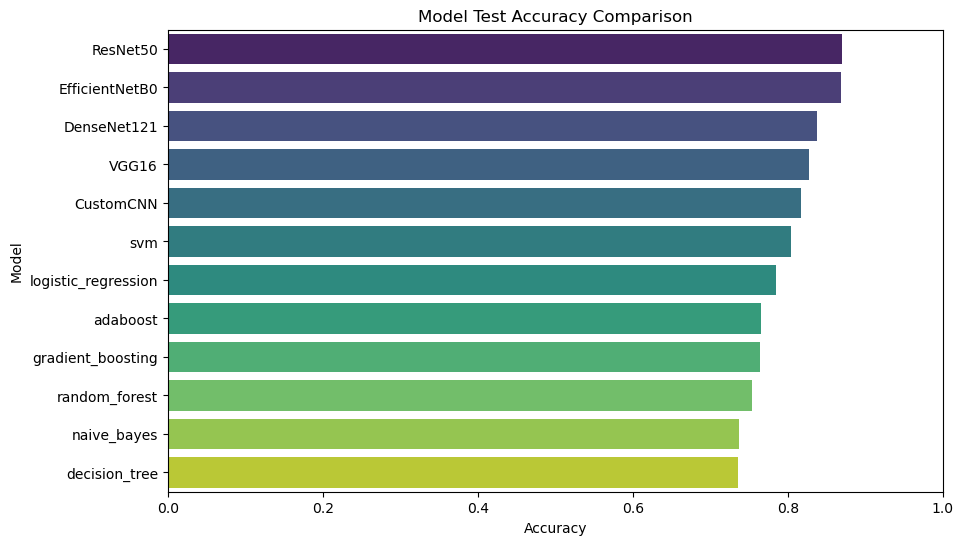

In [13]:
plt.figure(figsize=(10,6))
sns.barplot(x='Accuracy', y='Model', data=df_all, palette='viridis')
plt.title("Model Test Accuracy Comparison")
plt.xlabel("Accuracy")
plt.ylabel("Model")
plt.xlim(0.0, 1.0)
plt.show()


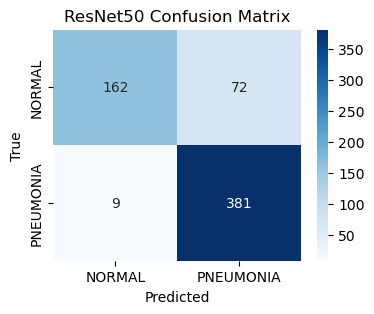

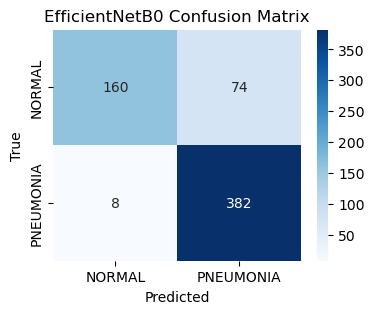

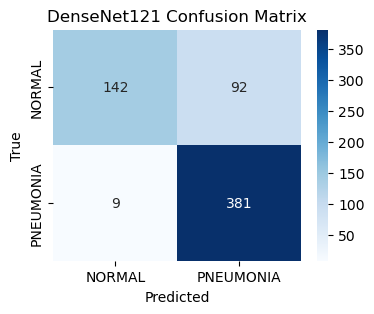

In [14]:
# Confusion matrices for top 3 models
for i in range(min(3, len(df_all))):
    cm = df_all.loc[i, 'Confusion Matrix']
    model_name = df_all.loc[i, 'Model']
    plt.figure(figsize=(4,3))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=CLASSES, yticklabels=CLASSES)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title(f'{model_name} Confusion Matrix')
    plt.show()
